## Image classification using CNN for Diabetic Retinopathy
Imagine this we are a start up. Seeking to develop a deep learning model That can detect and classify different types of diabetic retinopathy.

### What is Diabetic Retinopathy?
People with diabetes can have an eye disease called diabetic retinopathy. This is when high blood sugar levels cause damage to blood vessels in the retina. These blood vessels can swell and leak. Or they can close, stopping blood from passing through. Sometimes abnormal, new blood vessels grow on the retina. All of these changes can steal your vision.

#### The 4 classifications of Diabetic Retinopathy
The purpose here is to build a model that can distinguish between the various levels of diabetic retinopathy.

#### The Levels of Diabetic Retinopathy
This dataset analyzes the various levels of diabetic retinopathy and are classified as such:

***Stage 0*** - Healthy eyes

***Stage 1*** - Mild nonproliferative diabetic retinopathy.

***Stage 2*** - Moderate nonproliferative diabetic retinopathy

***Stage 3*** - Severe nonproliferative diabetic retinopathy.

***Stage 4*** - Proliferative diabetic retinopathy.

![DR](https://www.eyecaresurgerycenterbr.com/wp-content/uploads/2016/01/diabetic-retinopathy3.png)

In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

2023-01-22 22:30:52.807053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading Dataset
Since our dataset is seperated by training, validation and testing.

***Training data*** builds the machine learning model. It teaches what the expected output looks like.

***Validation data*** provides an unbiased evaluation of a model fit on the training data set

***Test data*** is a dataset used to provide an unbiased evaluation of a final model fit on the training data set.

In [2]:
#Setting up Directory's

#Train images Directory
train_dir = 'input/diabetic-retinopathy-balanced/train/'
#Test Images Directory
test_dir = 'input/diabetic-retinopathy-balanced/test/'
#Validation Images Directory
val_dir = 'input/diabetic-retinopathy-balanced/val/'

### Visualization of dataset

First we define a function called load_dataset, the purpose here is to help us then create a sample DataFrame which will then be used to load a sample image.

Next, I also use a data visualization tool called seaborn, to look at the distribution of the dataset. Ensure data is equally distributed. If not, additionally preprocessing will need to be done before getting started

In [3]:
#defining function to load datasets for visualization purposes
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [4]:
#Creating Sample Training dataFrame for image visualization
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_dir)
train.head()

0 Completed
1 Completed
4 Completed
3 Completed
2 Completed


,image,label
0,input/diabetic-retinopathy-balanced/train/0/22...,0
1,input/diabetic-retinopathy-balanced/train/0/34...,0
2,input/diabetic-retinopathy-balanced/train/0/17...,0
3,input/diabetic-retinopathy-balanced/train/0/14...,0
4,input/diabetic-retinopathy-balanced/train/0/23...,0


<AxesSubplot:xlabel='label', ylabel='count'>

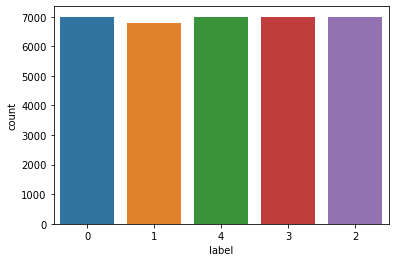

In [5]:
#Performing data visualization on image distribution. 
sns.countplot(train['label'])

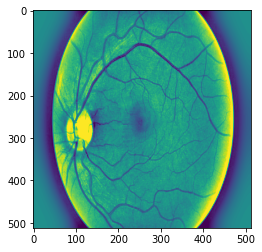

In [6]:
#Loading sample image from training dataset
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img)

### Creating dataset
First we will set our parameters which are to be used when creating the dataset.

Using ***tf.keras.utils.image_dataset_from_directory***, this will pull images from the set directory to make a dataset. Using this method, we will create the test, train, and validation datasets.

Also the first 9 images of the dataset are pulled for display.

In [7]:
#setting parameters
batch_size = 32
img_height = 180
img_width = 180

image_size = img_height, img_width

In [8]:
#Images Directory
train_dir = 'input/diabetic-retinopathy-balanced/train/'
test_dir = 'input/diabetic-retinopathy-balanced/test/'
val_dir = 'input/diabetic-retinopathy-balanced/val/'

In [9]:
#Creating Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=777,
    image_size = (img_height, img_width),
    batch_size = (batch_size))

Found 34792 files belonging to 5 classes.


2023-01-22 22:31:05.462801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#Creating Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed = 777,
    image_size = (img_height, img_width),
    batch_size= (batch_size))

Found 9940 files belonging to 5 classes.


In [11]:
#Creating Test Dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed = 777,
    image_size = (img_height, img_width),
    batch_size= (batch_size))

Found 4971 files belonging to 5 classes.


['0', '1', '2', '3', '4']


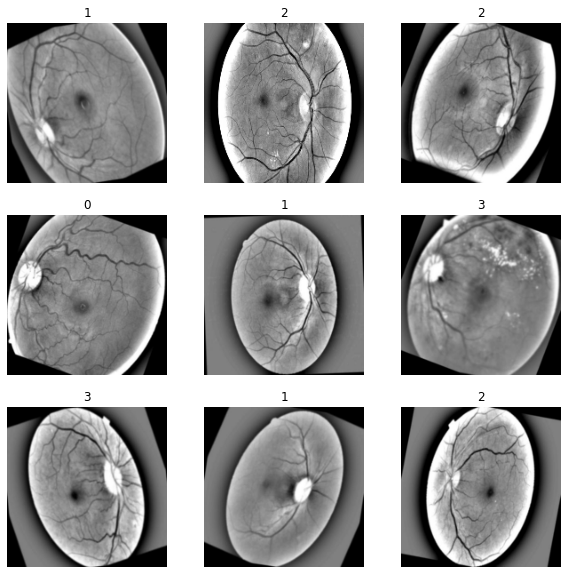

In [12]:
#First 9 images from training set

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### Configuring the dataset for performance
Using **Dataset.prefetch** overlaps data preprocessing and model execution while training.

The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. 

To avoid doing so, I set it to **tf.data.AUTOTUNE***, which will prompt the dataset runtime to tune the value dynamically at runtime.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

### Building the Model

I will be using a **Sequential Model** here first, to build the **Convolutional Neural Network** or **CNN** model which will be used.

Then the following layers are added

1) **Conv2D** (e.g. spatial convolution over images). This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.

2) **MaxPooling2D** This passes a moving window over the image and downscales the image by outputting the maximum value within the window

3) **Dropout** Used to prevent overfitting of data

4) **Flatten** flattens the output from the convolutional part of the CNN into a one-dimensional feature vector which can be passed into the following fully connected layers.

5) **Dense** Fully connected layer where every input is connected to every output

In [14]:
#Instantiating our model with rescaling
model = Sequential([layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

num_classes = len(class_names)

#Adding Layers
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(164, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
#model.add(Dropout(0.2))
#fully connected layer
model.add(Dense(32, input_dim= 5, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(64, kernel_initializer = 'HeUniform', activation='relu'))
model.add(Dense(128, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(256, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(128, kernel_initializer = 'uniform', activation='relu'))
#prediction layer
model.add(Dense(num_classes, name = 'preds'))


### Compiling & Fitting the model 
When compiling the model, we introduce a learning rate of 0.001, to increase accuracy when training the model.

The **Adam** will be used as an Optimizer.

The Loss will **tf.keras.losses.SparseCategoricalCrossentropy** which Computes the crossentropy loss between the labels and predictions, we also use it with from_**logits=True** since the model provides a linear output.

When fitting the model, I use 10 epochs.

Validation dataset is included as a parameter under validation_data.

In [15]:
#setting parameters for base rate
base_learning_rate = 0.001

#Compiling the model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

In [17]:
#Number of Epochs used in training
epochs = 15

#Fitting the data and running our model
main_history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs= epochs)

Epoch 1/15
1088/1088 [==============================] - 873s 801ms/step - loss: 1.3605 - accuracy: 0.3611 - val_loss: 1.2980 - val_accuracy: 0.3871
Epoch 2/15
1088/1088 [==============================] - 755s 694ms/step - loss: 1.2980 - accuracy: 0.3812 - val_loss: 1.2740 - val_accuracy: 0.3955
Epoch 3/15
1088/1088 [==============================] - 799s 734ms/step - loss: 1.2669 - accuracy: 0.4044 - val_loss: 1.2289 - val_accuracy: 0.4399
Epoch 4/15
1088/1088 [==============================] - 759s 697ms/step - loss: 1.2337 - accuracy: 0.4375 - val_loss: 1.2315 - val_accuracy: 0.4324
Epoch 5/15
1088/1088 [==============================] - 748s 687ms/step - loss: 1.2103 - accuracy: 0.4486 - val_loss: 1.2081 - val_accuracy: 0.4545
Epoch 6/15
1088/1088 [==============================] - 746s 686ms/step - loss: 1.1903 - accuracy: 0.4617 - val_loss: 1.1976 - val_accuracy: 0.4703
Epoch 7/15
1088/1088 [==============================] - 807s 742ms/step - loss: 1.1685 - accuracy: 0.4746 - val_

### Visualization of Model Performance

In [18]:
acc = main_history.history['accuracy']
val_acc = main_history.history['val_accuracy']
loss = main_history.history['loss']
val_loss = main_history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

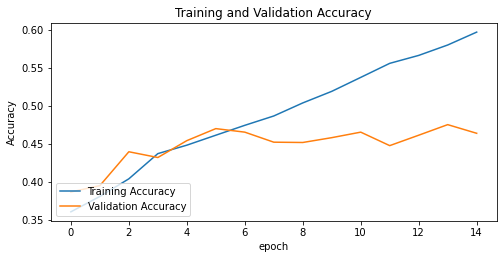

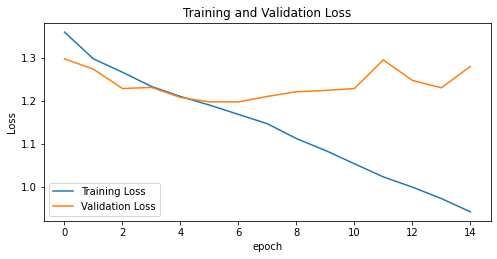

In [19]:
#Visualization for Training and Validation Accuracy
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower left")
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title("Training and Validation Accuracy")

#Data Visualization for Training and Validation Loss
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = "lower left")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Training and Validation Loss")

### Transfer Learning 

#### Creating base model from the pre-trained model

With Regards to transfer learning I will be using the MobileNet model developed at Google. This model is pre-trained on the 'ImageNet' dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories. This base of knowledge will help us classify the different levels of diabetic retinopathy from our specific dataset.

First, instantiate a MobileNet model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [20]:
#Creating the base model from the pre-trained model MobileNet
from keras.applications import MobileNet

cnn_base = MobileNet(weights ='imagenet', include_top = False,input_shape =(img_height, img_width, 3) )

In [21]:
#Taking a look at the base model architecture
cnn_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 90, 90, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 90, 90, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 90, 90, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 90, 90, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 90, 90, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 11, 11, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 11, 11, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 11, 11, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 11, 11, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 11, 11, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 11, 11, 512)       262144    
                                                                 
 conv_pw_9

### Building the model Using Transfer Learning

Using the **Sequential Model** here first. This time we will apply the pre-built **MobileNet** CNN Parameters to our model.

The following layers are added:

1) **cnn_base** This is the pre-built MobileNet CNN Model

2) **MaxPooling2D** This passes a moving window over the image and downscales the image by outputting the maximum value within the window

3) **Dropout** Used to prevent overfitting of data

4) **Flatten** flattens the output from the convolutional part of the CNN into a one-dimensional feature vector which can be passed into the following fully connected layers.

5) **Dense** Fully connected layer where every input is connected to every output

In [22]:
#Generating model layers
from keras import models
from keras import layers
from keras import optimizers

num_classes = len(class_names)

model = models.Sequential([layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))])
model.add(cnn_base)
#ADDING LAYERS
model.add(Dropout(0.2))
model.add(layers.MaxPooling2D())
#model.add(Dropout(0.2))
model.add(layers.Flatten())
#model.add(Dropout(0.2))
#fully connected Dense Layers
model.add(Dense(64, kernel_initializer = 'he_uniform', activation = 'relu'))
model.add(Dense(128, kernel_initializer = 'he_uniform', activation = 'relu'))
model.add(Dense(256, kernel_initializer = 'he_uniform', activation = 'relu'))
model.add(Dense(128, kernel_initializer = 'he_uniform', activation = 'relu'))
model.add(Dense(64, kernel_initializer = 'he_uniform', activation = 'relu'))
#prediction layer
model.add(Dense(num_classes, name = 'preds'))

### Feature extraction
In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor. 

#### Freezing the convolutional base
It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting **layer.trainable = False**) prevents the weights in a given layer from being updated during training. MobileNet has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [23]:
#Checking whether layer is trainable
for layer in model.layers:
    print(layer.name, layer.trainable) 

rescaling_1 True
mobilenet_1.00_224 True
dropout_2 True
max_pooling2d_3 True
flatten_1 True
dense_5 True
dense_6 True
dense_7 True
dense_8 True
dense_9 True
preds True


In [24]:
#freezing cnn_base layer
cnn_base.trainable = False

#Verification cnn_base model is frozen
for layer in model.layers:
    print(layer.name, layer.trainable) 

rescaling_1 True
mobilenet_1.00_224 False
dropout_2 True
max_pooling2d_3 True
flatten_1 True
dense_5 True
dense_6 True
dense_7 True
dense_8 True
dense_9 True
preds True


In [25]:
#model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 1024)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 1024)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 64)               

### Compiling & Fitting the model 
Just as before we will use the **Adam** Optimizer, and **SparseCategoricalCrossentropy** loss just as before, as well as the same learning rate.

Validation dataset is included as a parameter under validation_data.

In [26]:
#compiling the model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs = epochs)

Epoch 1/15
1088/1088 [==============================] - 818s 751ms/step - loss: 1.2574 - accuracy: 0.4709 - val_loss: 1.1309 - val_accuracy: 0.4985
Epoch 2/15
1088/1088 [==============================] - 763s 701ms/step - loss: 1.0858 - accuracy: 0.5345 - val_loss: 1.0690 - val_accuracy: 0.5465
Epoch 3/15
1088/1088 [==============================] - 754s 693ms/step - loss: 1.0354 - accuracy: 0.5563 - val_loss: 1.0288 - val_accuracy: 0.5517
Epoch 4/15
1088/1088 [==============================] - 752s 691ms/step - loss: 1.0014 - accuracy: 0.5718 - val_loss: 1.0330 - val_accuracy: 0.5520
Epoch 5/15
1088/1088 [==============================] - 753s 692ms/step - loss: 0.9795 - accuracy: 0.5844 - val_loss: 1.0070 - val_accuracy: 0.5637
Epoch 6/15
1088/1088 [==============================] - 752s 691ms/step - loss: 0.9602 - accuracy: 0.5922 - val_loss: 1.0412 - val_accuracy: 0.5466
Epoch 7/15
1088/1088 [==============================] - 756s 695ms/step - loss: 0.9402 - accuracy: 0.6036 - val_

### Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet base model as a fixed feature extractor.

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

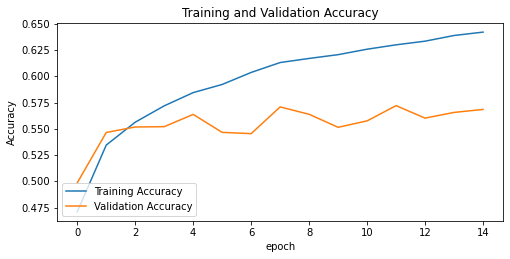

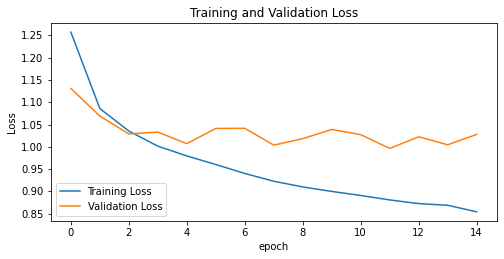

In [29]:
#Visualization for Training and Validation Accuracy after transfer learning
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower left")
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title("Training and Validation Accuracy")

#Data Visualization for Training and Validation Loss after Transfer learning
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = "lower left")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Training and Validation Loss")

### Fine Tuning
#### Un-freezing the top layers of the model

Consists of unfreezing the part of the model, and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

In [30]:
#Unfreezing the base model
cnn_base.trainable = True

In [31]:
#Counting number of layers are in the base model
print("number of layers in the base model:", len(cnn_base.layers))

#Fine tuning from this layer forwards
fine_tune_at = len(cnn_base.layers)

#Freezing the layers before the 'fine_tune_at' layer
for layer in cnn_base.layers[:fine_tune_at]:
    layer.trainable = False

number of layers in the base model: 86


In [32]:
#Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 1024)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 1024)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 64)               

### Compiling & Fitting the model 
Just as before we will use the **Adam** Optimizer, and **SparseCategoricalCrossentropy** loss just as before, as well as a decreased (smaller value) learning rate which is required with tuning.

Only change here is we are continuing our training from where our model last stopped. and adding an additional 10 extra epochs to this mode..

Validation dataset is included as a parameter under validation_data.

In [33]:
#compiling the model

#decreasing learning rate as a part of fine tuning
new_learning_rate = 0.0001

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=new_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
#Running The Model

new_epochs = epochs + 15

historyfined = model.fit(train_ds,
                        epochs = new_epochs,
                        initial_epoch = history.epoch[-1],
                        validation_data=val_ds)

Epoch 15/30
1088/1088 [==============================] - 752s 690ms/step - loss: 0.7997 - accuracy: 0.6650 - val_loss: 1.0167 - val_accuracy: 0.5732
Epoch 16/30
1088/1088 [==============================] - 753s 692ms/step - loss: 0.7922 - accuracy: 0.6710 - val_loss: 1.0048 - val_accuracy: 0.5808
Epoch 17/30
1088/1088 [==============================] - 754s 693ms/step - loss: 0.7864 - accuracy: 0.6716 - val_loss: 1.0157 - val_accuracy: 0.5758
Epoch 18/30
1088/1088 [==============================] - 754s 693ms/step - loss: 0.7845 - accuracy: 0.6731 - val_loss: 1.0105 - val_accuracy: 0.5804
Epoch 19/30
1088/1088 [==============================] - 754s 693ms/step - loss: 0.7828 - accuracy: 0.6731 - val_loss: 1.0133 - val_accuracy: 0.5777
Epoch 20/30
1088/1088 [==============================] - 755s 694ms/step - loss: 0.7833 - accuracy: 0.6721 - val_loss: 1.0135 - val_accuracy: 0.5791
Epoch 21/30
1088/1088 [==============================] - 760s 698ms/step - loss: 0.7783 - accuracy: 0.6754

#### Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet base model after fine tuning.

In [35]:
acc = historyfined.history['accuracy']
val_acc = historyfined.history['val_accuracy']
loss = historyfined.history['loss']
val_loss = historyfined.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

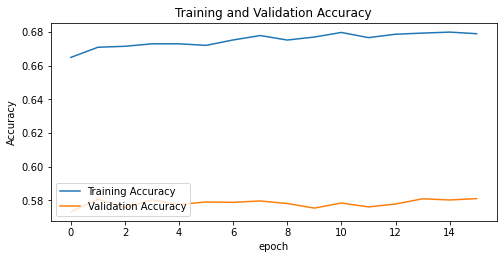

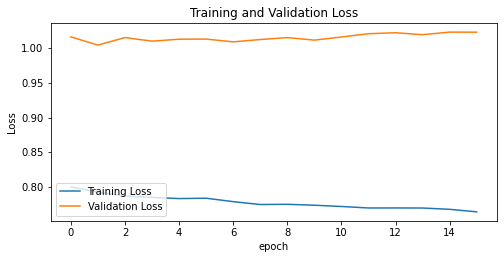

In [36]:
#Visualization for Training and Validation Accuracy after Fine Tuning
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower left")
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title("Training and Validation Accuracy")

#Data Visualization for Training and Validation Loss after Fine Tuning
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = "lower left")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Training and Validation Loss")